<center>

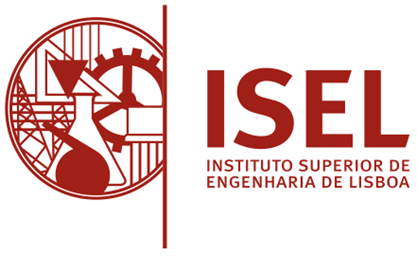
<h2>
Instituto Superior de Engenharia de Lisboa

Licenciatura Engenharia Informática e Multimédia

Ano letivo 2024/2025

Aprendizagem Automática

Trabalho concretizado pelos alunos:

Benjamim Noronha N.º 50731

Gonçalo Clementino N.º 50736

Francisco de Sousa N.º 50795


Docente: Gonçalo Silva

<h2>

29 de dezembro de 2024
</center>


## Introdução

<h4>
No âmbito da unidade curricular Aprendizagem Automática, foi realizado o segundo trabalho prático, com o intuito de cumprir os objetivos propostos no enunciado deste.
<br>

Dado um ficheiro que contém críticas cinematográficas, e as respetivas classificações atribuídas pelos utilizadores (numa escala de 1 a 4 e 7 a 10), que provém do site IMDb, tem-se como objetivos:
- Treinar um classificador multi-classe, com o propósito de prever a classificação de uma dada crítica com base no texto da mesma;
- Treinar e avaliar um regressor que preveja a pontuação da crítica;
- Realizar o clustering das críticas.

Ao longo do trabalho serão utilizados o modelo TfidfVectorizer, os classificadores Logistic Regression e Support Vetor Machine, os regressores Linear Regression, Ridge e Lasso e o algoritmo de clustering K-Means.
</h4>

In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import re
from nltk.stem import SnowballStemmer, PorterStemmer, LancasterStemmer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import sklearn.preprocessing as pp
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge, Lasso, LinearRegression

from plotMatriz import plotMatriz

#### Carregamento os dados do IMDb

In [2]:
file = open("imdbFull.p", "rb")
dados = pickle.load(file)

In [3]:
print(dados.keys())

dict_keys(['data', 'target', 'DESCR'])


#### Divisão dos dados em criticas de texto (variável Docs), e respetivas pontuações (variável y)

In [4]:
Docs = dados['data']
y = dados['target']
des = dados['DESCR']
des

'This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.\nFor more details see: http://ai.stanford.edu/~amaas/data/sentiment/'

#### Como as criticas já estão em String, não é necessário nenhum tipo de conversão.

In [5]:
print(type(Docs[1]))
print(Docs[0])

<class 'str'>
Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


## Construção do vocabulário

<h4> 
No âmbito da construção do vocabulário, uma etapa crucial para otimizar o desempenho dos modelos de classificação e regressão, procedeu-se a uma série de limpeza dos textos das críticas. Este processo visa a redução do ruído lexical, o realçar da relevância de determinadas palavras e, consequentemente, a melhora da eficiência dos algoritmos dos modelos, através da redução do número de palavras a processar.
<br>

O processo de limpeza das criticas passa por eliminar as tags HTML "br" (tag para quebra de linha), e remover números, pontuação e outros caracteres especiais, deixando apenas letras (incluindo letras acentuadas).
De seguida, é aplicado um filtro adicional que visa refinar o vocabulário, considerando apenas palavras com três ou mais caracteres, e que ocorram em pelo menos cinco criticas distintas.

Para a representação numérica do texto, optou-se pela utilização do método TfidfVectorizer. Esta ferramenta calcula o valor relativo de cada palavra nos documentos, atribuindo maior peso às palavras que ocorrem com maior frequência num determinado documento, mas penalizando aquelas que são comuns a vários documentos. A escolha deste método justifica-se pela sua capacidade de combinar as funcionalidades do método CountVectorizer (contagem de palavras) e do método TfidfTransformer (cálculo do valor relativo das palavras), numa única operação, proporcionando assim, uma maior eficiência computacional.
</h4>

In [6]:
# A conversão para String necessária caso as criticas estivessem num array de bytes (como nos videos)
# Docs1 = [doc.decode('UTF-8') for doc in Docs_ps]
Docs_normal = [doc.replace('<br />', ' ') for doc in Docs]
Docs_normal = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc)
               for doc in Docs_normal]

print(Docs_normal[1])

tfidf = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_normal)
X_ws = tfidf.transform(Docs_normal)

Words can t describe how bad this movie is I can t explain it by writing only You have too see it for yourself to get at grip of how horrible a movie really can be Not that I recommend you to do that There are so many clichés mistakes and all other negative things you can imagine here that will just make you cry To start with the technical first there are a LOT of mistakes regarding the airplane I won t list them here but just mention the coloring of the plane They didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original Boeing livery Very bad The plot is stupid and has been done many times before only much much better There are so many ridiculous moments here that i lost count of it really early Also I was on the bad guys side all the time in the movie because the good guys were so stupid Executive Decision should without a doubt be you re choice over this one even the Turbulence movies are better In fact every other movie 

## Pré-processamento de dados

<h4>
É realizada a divisão das criticas em dados de treino e dados de teste, além disso, faz-se o pré-processamento dos dados. O objetivo deste processo é avaliar o potencial impacto da aplicação do mesmo na melhoria dos resultados dos modelos. É importante salientar que, neste processo, optou-se por não efetuar a subtração da média, uma vez que se está a operar sobre uma matriz esparsa.
</h4>

In [7]:
X_ws1, X_ws2, ytreino, yteste = train_test_split(
    X_ws, y, test_size=0.2, random_state=0
)
sc = pp.StandardScaler(with_mean=False)
sc1 = sc.fit(X_ws1)

XtreinoN = sc1.transform(X_ws1)
XtesteN = sc1.transform(X_ws2)

<h4>
Recorreu-se à regressão logística como classificador inicial. O objetivo nesta etapa não se centra na classificação propriamente dita, mas sim na obtenção de uma perspetiva geral sobre o desempenho do classificador, tanto nos dados de treino, como nos de teste, e na realização de uma comparação entre os resultados obtidos com, e sem a aplicação do pré-processamento de dados.
<br>

A análise dos resultados revelou que a utilização do pré-processamento de dados resultou numa diminuição significativa do desempenho do classificador. Esta diminuição deve-se a um evidente overfitting, caracterizado por uma pontuação elevada nos dados de treino, acompanhada de uma discrepância acentuada entre as pontuações dos dados de treino e de teste, sendo estas últimas consideravelmente inferiores. A explicação para este fenómeno acenta na decisão metodológica de não se subtrair a média, durante o processo de pré-processamento dos dados.
</h4>

In [8]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ws1, ytreino)
print(dl.score(X_ws1, ytreino), "de score de treino")
print(dl.score(X_ws2, yteste), "de score de teste")

0.672475 de score de treino
0.4417 de score de teste


In [9]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(XtreinoN, ytreino)
print(dl.score(XtreinoN, ytreino), "de score de treino")
print(dl.score(XtesteN, yteste), "de score de teste")

0.999875 de score de treino
0.3635 de score de teste


<h4>
Nesta etapa, criam-se stemmers, que servem para reduzir cada palavra, à sua palavra raiz (que pode nem existir no dicionario), que serve para mapear várias palavras semelhantes, reduzindo a quantidade total de palavras. 
<br>

São usados 3 stemmers de diferentes tipos, sendo estes, Porter, Snowball e Lacaster, sendo o Lacaster o que tem mais poder de redução, e o Porter o que tem menos.
<br>

Também são utilizados classificadores simples para observar, por alto, os resultados dados a estes stemmers e compará-los, para depois utilizar um destes vocabulários para a classificação.
</h4>

In [10]:
stemFunc = PorterStemmer()

Docs_ps = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ps[1])

tfidf_ps = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ps)
X_ps = tfidf_ps.transform(Docs_ps)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clichés mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [11]:
X_ps1, X_ps2, ytreino_ps, yteste_ps = train_test_split(
    X_ps, y, test_size=0.2, random_state=0
)

In [12]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ps1, ytreino_ps)
print(dl.score(X_ps1, ytreino_ps), "de score de treino")
print(dl.score(X_ps2, yteste_ps), "de score de teste")

0.675425 de score de treino
0.4401 de score de teste


In [13]:
stemFunc = SnowballStemmer(language='english')

# Docs1 = [doc.decode('UTF-8') for doc in Docs_ss] #ja estão em str, n é byte
Docs_ss = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ss[1])

tfidf_ss = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ss)
X_ss = tfidf_ss.transform(Docs_ss)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clichés mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [14]:
X_ss1, X_ss2, ytreino_ss, yteste_ss = train_test_split(
    X_ss, y, test_size=0.2, random_state=0
)

In [15]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ss1, ytreino_ss)
print(dl.score(X_ss1, ytreino_ss), "de score de treino")
print(dl.score(X_ss2, yteste_ss), "de score de teste")

0.674325 de score de treino
0.4414 de score de teste


In [16]:
stemFunc = LancasterStemmer()

# Docs_ls1 = [doc.decode('UTF-8') for doc in Docs_ls] #ja estão em str, n é byte
Docs_ls = [''.join(stemFunc.stem(d)) for d in Docs_normal]

print(Docs_ls[1])

tfidf_ls = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b').fit(Docs_ls)
X_ls = tfidf_ls.transform(Docs_ls)

words can t describe how bad this movie is i can t explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clichés mistakes and all other negative things you can imagine here that will just make you cry to start with the technical first there are a lot of mistakes regarding the airplane i won t list them here but just mention the coloring of the plane they didn t even manage to show an airliner in the colors of a fictional airline but instead used a painted in the original boeing livery very bad the plot is stupid and has been done many times before only much much better there are so many ridiculous moments here that i lost count of it really early also i was on the bad guys side all the time in the movie because the good guys were so stupid executive decision should without a doubt be you re choice over this one even the turbulence movies are better in fact every other movie 

In [17]:
X_ls1, X_ls2, ytreino_ls, yteste_ls = train_test_split(
    X_ls, y, test_size=0.2, random_state=0
)

In [18]:
dl = LogisticRegression(max_iter=1000, random_state=0).fit(X_ls1, ytreino_ls)
print(dl.score(X_ls1, ytreino_ls), "de score de treino")
print(dl.score(X_ls2, yteste_ls), "de score de teste")

0.67215 de score de treino
0.4416 de score de teste


#### É de reparar que a diferença entre os stremmers é pequena, sendo que o Lacaster foi o que teve melhor pontuação, e o Porter a pior. Ainda assim, estes têm, por pouco, piores resultados que o vocabulário sem stemmers.

#### Apesar dos resultados, ainda é utilizado o vocabulário com stemmer no objetivo da classificação e regressão, uma vez que é eficaz em termos de tempo, visto que, pelo seu tamanho reduzido, os modelos são processados mais rapidamente, mesmo que haja perda alguma informação.

#### Com isto, tomou-se a decisão de usar o stemmer Snowball ao ínves do Lacaster, esta escolha tem repercussões nas próximas etapas.

## Classificação

### 20 min o gridsearch

#### É utilizada a Logistic Regression como classificador, devido ao seu ótimo desempenho, sendo também deduzidos os melhores híper-parametros deste classificador, para se obter um melhor comportamento. Para os encontrar, é utilizado o modelo grid search, e verificam-se os hiper-parametros C (força inversa à regularização), tipo de penalidade (l1 de lasso, e l2 de ridge), e tipo de otimização (solver, que pode ser saga, para suportar o l1, e lbfgs, que não suporta l1), todos estes usando apenas como recurso, as críticas de treino (lembrando que o gridsearch já faz uma divisão dos dados de treino, gerando dados de validação como referência)

In [19]:
""" param_grid_logreg = {
    'C': np.arange(0.1, 1.3, 0.1),
    'penalty': np.array(['l1', 'l2']),
    'solver': np.array(['saga', 'lbfgs'])

}
grid_search_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=0), param_grid_logreg, n_jobs=-1)
grid_search_logreg.fit(X_ss1, ytreino_ss)
logreg_params = grid_search_logreg.best_params_
print("Best Parameters:", logreg_params)
print("Best Score:", grid_search_logreg.best_score_) """

' param_grid_logreg = {\n    \'C\': np.arange(0.1, 1.3, 0.1),\n    \'penalty\': np.array([\'l1\', \'l2\']),\n    \'solver\': np.array([\'saga\', \'lbfgs\'])\n\n}\ngrid_search_logreg = GridSearchCV(\n    LogisticRegression(max_iter=1000, random_state=0), param_grid_logreg, n_jobs=-1)\ngrid_search_logreg.fit(X_ss1, ytreino_ss)\nlogreg_params = grid_search_logreg.best_params_\nprint("Best Parameters:", logreg_params)\nprint("Best Score:", grid_search_logreg.best_score_) '

#### Atribuição dos melhores híper-parametros determinados via gridsearch, esta atribuição é feita de modo a não haver uma complexidade temporal tão alta, visto que não tem que se executar o bloco de código acima comentado (que demorava 20 minutos em média).

In [20]:
logreg_params = {'C': np.float64(
    0.9), 'penalty': np.str_('l2'), 'solver': 'saga'}

#### Para as labels das próximas matriz de confusão

In [21]:
classes = np.array([1, 2, 3, 4, 7, 8, 9, 10])

<h4>
Utilizaram-se os melhores hiper-parâmetros no classificador LogisticRegression, que é treinado com o conjunto de treino, e com isso faz-se uma predição cruzada dos dados de teste, de maneira a obter-se a quantidade de erros na classificação, e a matriz de confusão. Igualmente, faz-se a validação cruzada do conjunto de teste, onde se obtém o desempenho geral do classificador com os seus hiper-parâmetros, onde se regista 43,73% de score nos dados de treino, e 41,16% de score nos dados de teste.

A vantagem da predição e validação cruzada é a consistência dos dados, onde o classificador não apanha um padrão de dados fáceis ou difíceis. Ainda assim, utilizou-se o score normal, sem validação cruzada, para se poder comparar com o classificador simples, desenvolvido anteriormente, quando era para escolher o stemmer.

Em comparação com o classificador simplificado, o score dos dados de treino, que não são da validação cruzada, diminuiu cerca de 1%, mas os de teste aumentaram cerca de 0,03%, ou seja, diminuiu ligeiramente o overfit.

Estes resultados fazem parecer que o desempenho do modelo é medíocre, na casa dos 40%, mas se relembrarmos que não é uma classificação binária e sim multiclasse de 8 (1 a 4 e 7 a 10), faz com que o desempenho do classificador seja bastante positivo.

5884 erros
0.662175
43.73 de score de treino
0.4417
41.16 de score de teste


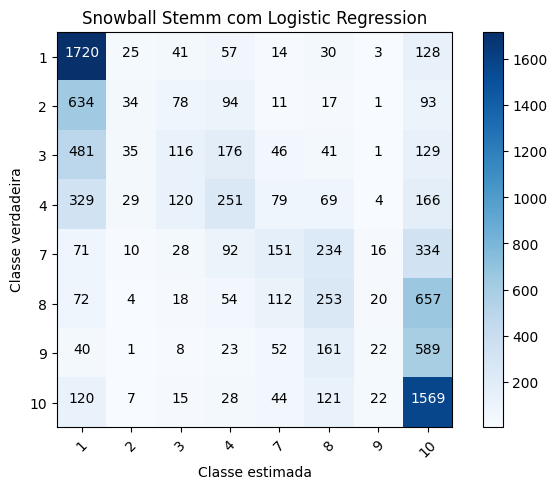

In [22]:
dl = LogisticRegression(**logreg_params, max_iter=1000,
                        random_state=0).fit(X_ss1, ytreino_ss)

predict_dl = cross_val_predict(dl, X_ss2, yteste_ss)
print(np.sum(predict_dl != yteste_ss), "erros")
cm = confusion_matrix(yteste_ss, predict_dl)


plotMatriz(cm, classes=classes, title="Snowball Stemm com Logistic Regression")

print(dl.score(X_ss1, ytreino_ss))
print(np.round(np.mean(cross_val_score(dl, X_ss1, ytreino_ss))*100, 2),
      "de score de treino")
print(dl.score(X_ss2, yteste_ss))
print(np.round(np.mean(cross_val_score(dl, X_ss2, yteste_ss))*100, 2),
      "de score de teste")

#### Neste ponto, as críticas foram classificadas recorrendo ao uso do vocabulário com recursoao Lacaster Stemmer, onde se obteve um resultado menos favorável que o anterior, visto que houve um pior valor de score na avaliação cruzada.

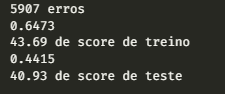

#### Ainda se desenvolveu o vocabulário usando o Snowball Stemmer, só que com bigramas, ou seja, um valor relativo pode ser desempenhado por duas palavras, ao invés de apenas uma.

#### A utilidade deste tipo de vocabulário é relevante em situações situações onde há uma sequência de palavras que alteram o significado de um texto, como "not good", que tem um significado negativo, em contrapartida, aumenta o ruído no valor relativo das palavras, que é um ponto que queremos verificar.

In [23]:
tfidf_ss_bi = TfidfVectorizer(
    min_df=5, token_pattern=r'\b\w\w\w+\b', ngram_range=(1, 2)).fit(Docs_ss)
X_ss_bi = tfidf_ss_bi.transform(Docs_ss)

In [24]:
X_ss1_bi, X_ss2_bi, ytreino_ss_bi, yteste_ss_bi = train_test_split(
    X_ss_bi, y, test_size=0.2, random_state=0
)

#### Verifica-se que o resultado é pior no desempenho do classificador, e há um aumento de overfit, tudo isto deve-se ao aumento do ruído.

6007 erros
44.27 de score de treino
39.93 de score de teste


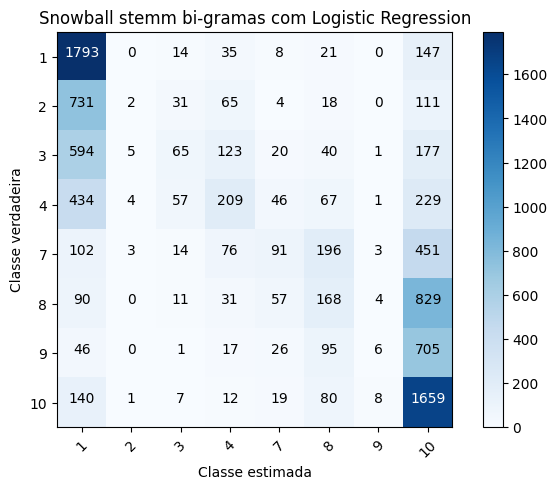

In [25]:
dl = LogisticRegression(**logreg_params, max_iter=1000,
                        random_state=0).fit(X_ss1_bi, ytreino_ss_bi)

predict_dl = cross_val_predict(dl, X_ss2_bi, yteste_ss_bi)
print(np.sum(predict_dl != yteste_ss_bi), "erros")
cm = confusion_matrix(yteste_ss_bi, predict_dl)
plotMatriz(cm, classes=classes,
           title="Snowball stemm bi-gramas com Logistic Regression")


print(np.round(np.mean(cross_val_score(dl, X_ss1_bi, ytreino_ss_bi))
      * 100, 2), "de score de treino")
print(np.round(np.mean(cross_val_score(dl, X_ss2_bi, yteste_ss_bi))
      * 100, 2), "de score de teste")

#### Ainda houve uma tentativa de uso de uma máquina de suporte a vetores simples no momento em que foi feita, sem gridsearch. No entanto, o tempo gasto, cerca de 67 minutos, e o resultado obtido, cerca de 20% de desempenho, foram suficientes para desconsiderar a utilização deste classificador. A célula foi comentada de modo a não ser executada, mas existe uma imagem que mostra o resultado da mesma.

In [26]:
""" dl = svm.SVC(C=1, tol=1e-3, gamma='auto').fit(X_ss1, ytreino)
print(dl.score(X_ss1, ytreino))
print(dl.score(X_ss2, yteste)) """

" dl = svm.SVC(C=1, tol=1e-3, gamma='auto').fit(X_ss1, ytreino)\nprint(dl.score(X_ss1, ytreino))\nprint(dl.score(X_ss2, yteste)) "

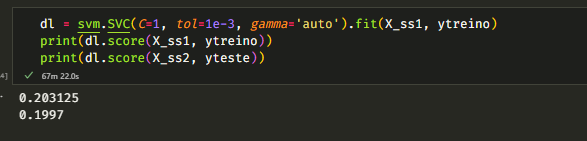


## Regressores

#### Nesta etapa, usam-se regressores para prever a pontuação da crítica, sendo esta um número contínuo.

#### Usou-se inicialmente a LinearRegression simples, onde o coeficiente R2 (coeficiente de determinação), que serve para indicar a qualidade do ajuste do modelo na regressão, é bastante alto, cerca de 97%. Em contrapartida, o erro médio absoluto e quadrático são altos, principalmente o quadrático.

In [27]:
model = LinearRegression(n_jobs=-1).fit(X_ss1, ytreino_ss)

y_pred_lr_train = model.predict(X_ss1)
y_pred_lr_test = model.predict(X_ss2)

print("R² no treino:", r2_score(ytreino_ss, y_pred_lr_train))

print("Erro médio absoluto (MAE) no teste:",
      mean_absolute_error(yteste_ss, y_pred_lr_test))
print("Erro médio quadrático (MSE) no teste:",
      mean_squared_error(yteste_ss, y_pred_lr_test))

R² no treino: 0.9741590527445843
Erro médio absoluto (MAE) no teste: 6.629555936170752
Erro médio quadrático (MSE) no teste: 84.39618418990477


#### Usando o resultado obtido pelo regressor, é possível manipular o mesmo, de maneira a classificar as críticas, mas para tal, é necessário transformar o resultado contínuo em discreto. De seguida, limitam-se as pontuações, isto é, não existe pontuação acima de 10, ou abaixo de 1, e não existe pontuação que seja 5 ou 6. A pergunta que fica é: será que é possível substituir os modelos de classificação utilizando os regressores? Saberemos a resposta no final deste capítulo.

#### Por fim, verificamos quantos erros são provocados, o seu score e a matriz de confusão, neste caso, houve cerca de 22% de acertos, e 7732 erros.

0.2268
7732 erros


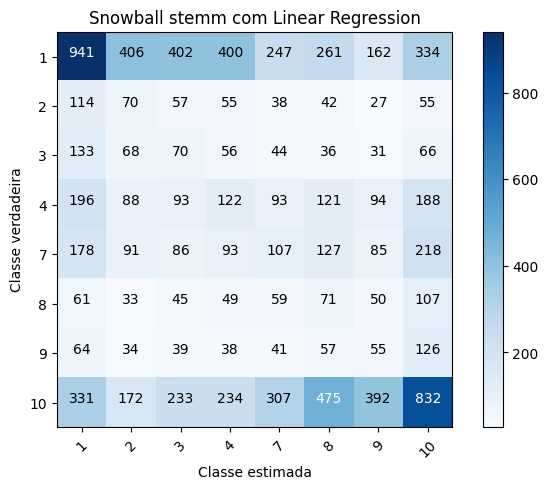

In [28]:
# print(y_pred_lr_test)
y_pred_lr_class_test = np.round(y_pred_lr_test)
y_pred_lr_class_test[y_pred_lr_class_test > 10.] = 10.
y_pred_lr_class_test[y_pred_lr_class_test < 1.] = 1.
y_pred_lr_class_test[y_pred_lr_class_test == 5.] = 4.
y_pred_lr_class_test[y_pred_lr_class_test == 6.] = 7.
# print(y_pred_lr_class_test)

# print(y_pred_lr_class_test)
# print(ytreino_ss)
print(np.sum(y_pred_lr_class_test == yteste_ss)/len(yteste_ss))

print(np.sum(y_pred_lr_class_test != yteste_ss), "erros")
cm = confusion_matrix(y_pred_lr_class_test, yteste_ss)
plotMatriz(cm, classes=classes, title="Snowball stemm com Linear Regression")

#### O uso da LinearRegression levanta o problema da sobre-aprendizagem, onde, caso se mostrasse o R2 nas críticas de teste, seria gerado um resultado negativo. Para este problema ser resolvido, também são usados outros regressores que seguem o princípio da regressão linear, mas com certas penalizações, regularizando pesos elevados. Estes modelos são o Lasso (que soma ao erro quadrático, o valor absoluto dos pesos w com alpha), e o Ridge (que soma ao erro quadrático, o valor quadrático dos pesos w com alpha), onde alpha é o coeficiente de regularização.

#### Começamos por utilizar o modelo Lasso, para encontrar os seus melhores hiper-parâmetros alpha.

In [29]:
param_grid_lasso = {
    'alpha': np.array([1e-3, 1e-2, 1e-1, 1, 10])
}


grid_search_lasso = GridSearchCV(
    Lasso(random_state=0),  param_grid_lasso, n_jobs=-1
)
grid_search_lasso.fit(X_ss1, ytreino_ss)

lasso_params = grid_search_lasso.best_params_
print("Melhor valor de alpha:", lasso_params)
print("Melhor score de validação cruzada (R²):", grid_search_lasso.best_score_)

Melhor valor de alpha: {'alpha': np.float64(0.001)}
Melhor score de validação cruzada (R²): 0.5138510329547669


#### R2 é menor que do modelo LinearRegression, só que tem menores erros médios absoluto e quadrático.

In [30]:
las = Lasso(**lasso_params, random_state=0).fit(X_ss1, ytreino_ss)

y_las_1 = las.predict(X_ss1)
y_las_2 = las.predict(X_ss2)

print("R² no treino:", r2_score(ytreino_ss, y_las_1))


print("Erro médio absoluto (MAE) no teste:",
      mean_absolute_error(yteste_ss, y_las_2))
print("Erro médio quadrático (MSE) no teste:",
      mean_squared_error(yteste_ss, y_las_2))

R² no treino: 0.5208076257853331
Erro médio absoluto (MAE) no teste: 2.0290134643565185
Erro médio quadrático (MSE) no teste: 5.859619023047476


#### Ainda assim, houve um percentual de 21% de acertos e 7845 erros, inferiores aos da LinearRegression

0.2155
7845 erros


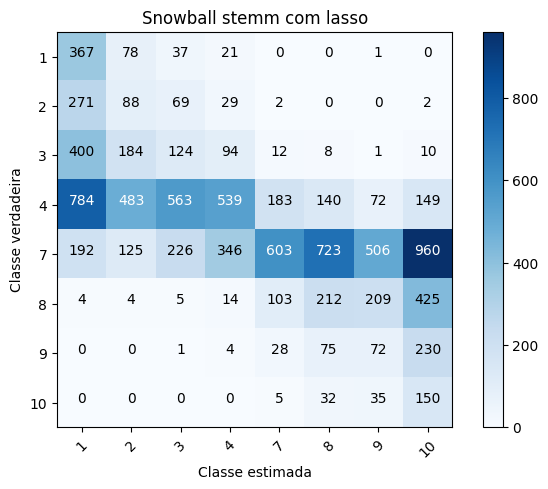

In [31]:
# print(y_las_2)
y_pred_las_class_test = np.round(y_las_2)
y_pred_las_class_test[y_pred_las_class_test > 10.] = 10.
y_pred_las_class_test[y_pred_las_class_test < 1.] = 1.
y_pred_las_class_test[y_pred_las_class_test == 5.] = 4.
y_pred_las_class_test[y_pred_las_class_test == 6.] = 7.

# print(y_pred_las_class_test)
# print(ytreino_ss)
print(np.sum(y_pred_las_class_test == yteste_ss)/len(yteste_ss))

print(np.sum(y_pred_las_class_test != yteste_ss), "erros")
cm = confusion_matrix(y_pred_las_class_test, yteste_ss)
plotMatriz(cm, classes=classes, title="Snowball stemm com lasso")

#### Execução do mesmo processo no Ridge

In [32]:
param_grid_ridge = {
    # Altere os valores de alpha conforme necessário
    'alpha': np.array([1e-3, 1e-2, 1e-1, 1, 10])
}

# Configurando o GridSearchCV
grid_search_ridge = GridSearchCV(
    Ridge(random_state=0),  param_grid_ridge, n_jobs=-1
)

# Ajustando o modelo
grid_search_ridge.fit(X_ss1, ytreino_ss)

# Obtendo os melhores parâmetros e score
ridge_params = grid_search_ridge.best_params_
print("Melhor valor de alpha:", ridge_params)
print("Melhor score de validação cruzada (R²):", grid_search_ridge.best_score_)

Melhor valor de alpha: {'alpha': np.float64(1.0)}
Melhor score de validação cruzada (R²): 0.6345658582084799


#### 79% de score no R2, erro médio absoluto e quadratico inferiores em comparação com LinearRegression e Lasso

In [33]:
rl = Ridge(**ridge_params, random_state=0).fit(X_ss1, ytreino_ss)

y_rl_1 = rl.predict(X_ss1)
y_rl_2 = rl.predict(X_ss2)

print("R² no treino:", r2_score(ytreino_ss, y_rl_1))

print("Erro médio absoluto (MAE) no teste:",
      mean_absolute_error(yteste_ss, y_rl_2))
print("Erro médio quadrático (MSE) no teste:",
      mean_squared_error(yteste_ss, y_rl_2))

R² no treino: 0.7904298284094093
Erro médio absoluto (MAE) no teste: 1.6788094416009998
Erro médio quadrático (MSE) no teste: 4.407504415925008


#### De modo geral, é obtida uma melhor pontuação na classificação entre os regressores, cerca de 26% de acertos e 7322 erros. Ainda assim, os regressores não chegam à altura dos modelos de classificação, de modo a conseguirem substituí-los, visto que os classificadores estão na casa dos 40% de acerto, contrariamente aos regressores, que no máximo atingem 26%.

0.2678
7322 erros


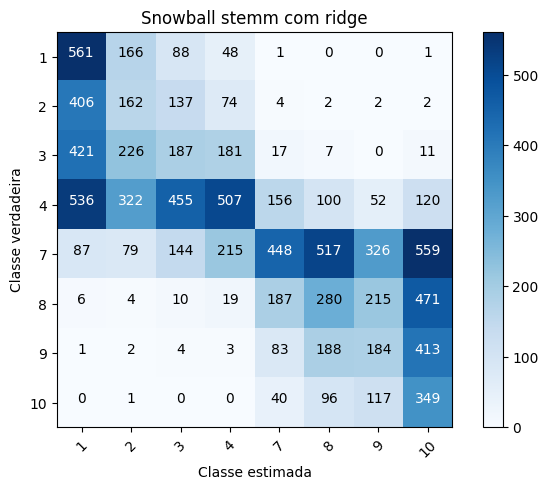

In [34]:
# print(y_rl_2)
y_pred_rl_class_test = np.round(y_rl_2)
y_pred_rl_class_test[y_pred_rl_class_test > 10.] = 10.
y_pred_rl_class_test[y_pred_rl_class_test < 1.] = 1.
y_pred_rl_class_test[y_pred_rl_class_test == 5.] = 4.
y_pred_rl_class_test[y_pred_rl_class_test == 6.] = 7.

# print(y_pred_rl_class_test)
# print(ytreino_ss)
print(np.sum(y_pred_rl_class_test == yteste_ss)/len(yteste_ss))

print(np.sum(y_pred_rl_class_test != yteste_ss), "erros")
cm = confusion_matrix(y_pred_rl_class_test, yteste_ss)
plotMatriz(cm, classes=classes, title="Snowball stemm com ridge")

## Cluster

<h4>

Nesta etapa, usam-se os clusters de maneira a observar que tópicos ou categorias podem existir num grupo de críticas.

Para isso, utilizamos o modelo KMeans, um modelo não supervisionado (que não tem em conta o target). Este modelo é treinado pelo vocabulário. No caso, o vocabulário utilizado é o que não tem stremmer, uma vez que será o utilizador a ler as críticas e as palavras.

Após o treino do modelo, atribuem-se os documentos ao respetivo cluster ao qual pertencem. Seguidamente, exibe-se a quantidade de documentos existentes, as 3 primeiras críticas, e as 20 palavras mais relevantes de cada cluster. Com isto, lemos as críticas e as 20 palavras mais relevantes e tentamos englobá-los num tópico, se fizer sentido.

In [35]:
words = np.array(tfidf.get_feature_names_out())

#### Com apenas 2 clusters não é possível observar tópico algum.

In [ ]:

optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_ws)

# Atribuindo os rótulos aos documentos
Docs_clusters = {i: [] for i in range(optimal_clusters)}
for idx, label in enumerate(kmeans.labels_):
    Docs_clusters[label].append(Docs_normal[idx])

# Analisando os tópicos em cada cluster
for cluster, docs in Docs_clusters.items():
    print(f"\nCluster {cluster}: {len(docs)} documentos")
    print("Exemplo de críticas:")
    for doc in docs[:3]:  # Exibindo 3 exemplos por cluster
        print(f"- {doc}...")  # Mostrando os primeiros 150 caracteres

# Exibir as 20 palavras mais relevantes por cluster
for cluster_idx, centroid in enumerate(kmeans.cluster_centers_):
    print(f"\nCluster {cluster_idx}:")
    top_indices = centroid.argsort()[-20:][::-1]
    top_words = words[top_indices]
    print(f"Top 20 palavras: {', '.join(top_words)}")


Cluster 0: 27690 documentos
Exemplo de críticas:
- Zero Day leads you to think even re think why two boys young men would do what they did commit mutual suicide via slaughtering their classmates It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own mutual world via coupled destruction It is not a perfect movie but given what money time the filmmaker and actors had it is a remarkable product In terms of explaining the motives and actions of the two young suicide murderers it is better than Elephant in terms of being a film that gets under our rationalistic skin it is a far far better film than almost anything you are likely to see Flawed but honest with a terrible honesty ...
- Everyone plays their part pretty well in this little nice movie Belushi gets the chance to live part of his life differently but ends up realizing that what he had was going to be just as good or maybe even better The

#### Com 4 clusters ainda não se observa nenhum tópico.

In [37]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_ws)

# Atribuindo os rótulos aos documentos
Docs_clusters = {i: [] for i in range(optimal_clusters)}
for idx, label in enumerate(kmeans.labels_):
    Docs_clusters[label].append(Docs_normal[idx])

# Analisando os tópicos em cada cluster
for cluster, docs in Docs_clusters.items():
    print(f"\nCluster {cluster}: {len(docs)} documentos")
    print("Exemplo de críticas:")
    for doc in docs[:3]:
        print(f"- {doc}...")

# Exibir as 20 palavras mais relevantes por cluster
for cluster_idx, centroid in enumerate(kmeans.cluster_centers_):
    print(f"\nCluster {cluster_idx}:")
    top_indices = centroid.argsort()[-20:][::-1]
    top_words = words[top_indices]
    print(f"Top 20 palavras: {', '.join(top_words)}")


Cluster 0: 3995 documentos
Exemplo de críticas:
-  Show People is an absolutely delightful silent directed by King Vidor and starring Marion Davies and Billy Haines What gems both of them are in this charming comedy about a young girl Peggy Pepper whose acting is the talk of Savannah trying to make it on the big screen Though she s a success in comedy what she wants to do is make art so she moves up to High Arts Studio Soon she becomes Patricia Pepoire and is too good for the likes of her friend Billy Many stars of the silent era have cameos in Show People including Davies herself without the curly hair and makeup I m sure when people saw the film in they recognized everyone who appeared in the elaborate lunch scene sadly nowadays it s not the case even for film buffs In one part of the film however she does meet Charlie Chaplin in another author Elinor Glyn is pointed out to her and Vidor himself has a cameo at the end of the film Other stars who pop up in Show People are John Gilber

#### Percebe-se o cluster 5 é sobre séries, diferente doutros clusters, que são sobre filmes, por isso este tem apenas 1507 documentos.

#### Apartir daqui, reduziu-se a quantidade de palavras por critica, de modo a ocupar menos espaço de ecrã.

In [38]:
optimal_clusters = 10
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_ws)

# Atribuindo os rótulos aos documentos
Docs_clusters = {i: [] for i in range(optimal_clusters)}
for idx, label in enumerate(kmeans.labels_):
    Docs_clusters[label].append(Docs_normal[idx])

# Analisando os tópicos em cada cluster
for cluster, docs in Docs_clusters.items():
    print(f"\nCluster {cluster}: {len(docs)} documentos")
    print("Exemplo de críticas:")
    for doc in docs[:3]:
        print(f"- {doc[:300]}...")


# Exibir as 10 palavras mais relevantes por cluster
for cluster_idx, centroid in enumerate(kmeans.cluster_centers_):
    print(f"\nCluster {cluster_idx}:")
    top_indices = centroid.argsort()[-20:][::-1]
    top_words = words[top_indices]
    print(f"Top 20 palavras: {', '.join(top_words)}")


Cluster 0: 3066 documentos
Exemplo de críticas:
-  Show People is an absolutely delightful silent directed by King Vidor and starring Marion Davies and Billy Haines What gems both of them are in this charming comedy about a young girl Peggy Pepper whose acting is the talk of Savannah trying to make it on the big screen Though she s a success in com...
- I love a good sappy love story and I m a guy but when I rented Love Story I prayed for the end to come as quickly and painlessly as possible and just the opposite for Ali McGraw s character Ali McGraw as Jenny alienated and irritated the heck out of me within the first minutes When we learn that she...
- Towards the end of this thriller Ally Sheedy s gaunt latter day image is used creatively to make up more than one hauntingly evil image She convinces one that if a nasty Bette Davis type role were to come her way she could carry it off brilliantly Unfortunately I can t find many other reasons for se...

Cluster 1: 9355 documentos
Exemp

#### O cluster 9 aborda filmes sobre artes marciais orientais, com cerca de 255 documentos, e o cluster 10 é referente a filmes de natal, com cerca de 225 documentos. Já os clusters 14 e 19 referem-se a séries, com 1182 e 917 documentos respetivamente.

In [39]:
optimal_clusters = 20
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_ws)

# Atribuindo os rótulos aos documentos
Docs_clusters = {i: [] for i in range(optimal_clusters)}
for idx, label in enumerate(kmeans.labels_):
    Docs_clusters[label].append(Docs_normal[idx])

# Analisando os tópicos em cada cluster
for cluster, docs in Docs_clusters.items():
    print(f"\nCluster {cluster}: {len(docs)} documentos")
    print("Exemplo de críticas:")
    for doc in docs[:3]:
        print(f"- {doc[:300]}...")


# Exibir as 10 palavras mais relevantes por cluster
for cluster_idx, centroid in enumerate(kmeans.cluster_centers_):
    print(f"\nCluster {cluster_idx}:")
    top_indices = centroid.argsort()[-20:][::-1]
    top_words = words[top_indices]
    print(f"Top 20 palavras: {', '.join(top_words)}")


Cluster 0: 5472 documentos
Exemplo de críticas:
- Sorry but every time I see a film wherein a woman sucker punches a man and the man does nothing but cower the film looses all credibility So the new female Starbuck immediately tainted the plot before it even got off the ground no pun intended Dirk Benedict was so much more plausible as the sensitiv...
- Engaging riveting tale of captured US army turncoat who has to prove his innocence to avoid the hangman Paul Ryker dodges friendly fire in a seemingly doomed attempt to convince a military court that he was actually a US spy on a secret mission in Korea In the vein of classic courtroom dramas Sergea...
- When I noticed that Hamish Macbeth was being broadcast in the United States I was thrilled I then had the misfortune to watch the darn thing I adore M C Beaton s books about the wonderful Scottish Constable The characters in the book are entertaining and very well written The powers that be who are ...

Cluster 1: 1194 documentos
Exemp

#### O cluster 1 aborda o tema "vampiros" (cerca de 234 documentos), o cluster 3 encapsula o género terror/horror (885 documentos), o cluster 7 é sobre filmes de zombies (246 documentos), o cluster 9 parece referir-se a filmes antigos, o cluster 14 é sobre artes marciais orientais (579 documentos), o cluster 17 é sobre o género "comédia" (849 documentos), o cluster 21 é referente à obra Looney Tunes (apenas 50 documentos, por ser uma obra específica e não um género audiovisual), e o cluster 25 refere-se a jogos ou adaptações de jogos para filmes (229 documentos).

In [40]:
optimal_clusters = 30
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_ws)

# Atribuindo os rótulos aos documentos
Docs_clusters = {i: [] for i in range(optimal_clusters)}
for idx, label in enumerate(kmeans.labels_):
    Docs_clusters[label].append(Docs_normal[idx])

# Analisando os tópicos em cada cluster
for cluster, docs in Docs_clusters.items():
    print(f"\nCluster {cluster}: {len(docs)} documentos")
    print("Exemplo de críticas:")
    for doc in docs[:3]:
        print(f"- {doc[:300]}...")


# Exibir as 10 palavras mais relevantes por cluster
for cluster_idx, centroid in enumerate(kmeans.cluster_centers_):
    print(f"\nCluster {cluster_idx}:")
    top_indices = centroid.argsort()[-20:][::-1]
    top_words = words[top_indices]
    print(f"Top 20 palavras: {', '.join(top_words)}")


Cluster 0: 2793 documentos
Exemplo de críticas:
- I had no idea that Mr Izzard was so damn funny It really boggles the mind that he is not more well known His command over the crowd and his timing is perfect The monologue about Star Wars will kill ya too If only all the stand up performers had his wit ...
- For those of you unfamiliar with Jimmy Stewart this is one of his lesser films from later in his career And while it isn t a great film compared to many of his other pictures it isn t bad and is a decent time passer but not much more Kim Novak is a witch in New York City and for some inexplicable re...
- Once again the same familiar story about a man writer here who sell his soul to the devil in order to have his most desired ambition in life success Unfunny script we should go home and write better ridiculous lines in order to understand the strong Christmanish message our only aspiration in life i...

Cluster 1: 234 documentos
Exemplo de críticas:
- I give this movie a as it is w

#### É de reparar que com poucos clusters, dificilmente se tem algum tópico, ou se se tivesse, seria algo superficial, como ser uma série ao invés de um filme. Agora, quanto mais clusters se começou a ter, mais tópicos foram sendo encontrados, distinguindo géneros, e até mesmo obras especificas.

## Conclusões 

<h4>
Neste trabalho foi possível criar vocabulário útil para os classificadores e regressores, entender melhor a classificação multi-classe, o uso dos regressores para prever a nota de cada crítica, e torná-los em classificadores, por fim, também foi possível usar clusters para observar os diferentes tópicos existentes.
<br><br>
O modelo da classificação multi-classe, LogisticRegression, obteve-se um ótimo desempenho, cerca de 41%, onde foi preciso fazer uso do GridSearch para encontrar os melhores híper-parametros deste. 

Os modelos de regressão tiveram um desempenho razoável, principalmente o Ridge, que teve um baixo valor de erros médios, enquanto foi notável que a LinearRegression sofreu de sobre-aprendizagem. Ainda assim, com o desempenho considerável dos regressores, transformando-os em classificadores, estes não conseguem substituir o trabalho dos modelos de classificação, devido ao seu fraco desempenho.

## Bibliografia

Marques, G. (2024). Slides da Moodle da unidade curricular.[PDF] https://2425moodle.isel.pt/course/view.php?id=8219 (último acesso a 28/12/2024)

Marques, G. (2024). Videos sobre o Lab Texto. https://www.youtube.com/playlist?list=PLfXF38gbMT6MuqiwseN6M9kWU6uUMxQjL (último acesso a 28/12/2024)